# Notebook 06: Model Comparison

## Mục Tiêu
- So sánh performance của các models: SARIMA, LightGBM, Prophet
- Benchmark trên các granularities khác nhau
- Chọn model tốt nhất cho autoscaling

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings

warnings.filterwarnings('ignore')

# Thêm src vào path
sys.path.insert(0, os.path.abspath('..'))

from src.data.preprocessor import load_timeseries, split_train_test
from src.features.feature_engineering import TimeSeriesFeatureEngineer
from src.models.sarima import SARIMAForecaster
from src.models.lightgbm_forecaster import LightGBMForecaster
from src.models.prophet_forecaster import ProphetForecaster, PROPHET_AVAILABLE
from src.models.evaluation import calculate_metrics, compare_models, print_metrics_table

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded!")
print(f"Prophet available: {PROPHET_AVAILABLE}")

Libraries loaded!
Prophet available: True


## 1. Load Data

In [ ]:
# Load 15-minute data
df = load_timeseries('../data/processed/timeseries_15min.parquet')
df_clean = df[df['is_storm_period'] == 0].copy()

# Train/Test split
train, test = split_train_test(df_clean, test_start='1995-08-23')

print(f"Train: {len(train)} samples")
print(f"Test: {len(test)} samples")

Train: 4937 samples
Test: 864 samples


In [ ]:
# Prepare data for different models
train_series = train['request_count']
test_series = test['request_count']

# For LightGBM - need features
fe = TimeSeriesFeatureEngineer(df_clean)
df_features = fe.create_all_features(target_col='request_count', granularity='15min')
feature_cols = fe.get_feature_columns(df_features)
X, y = fe.prepare_supervised(df_features, 'request_count', feature_cols, forecast_horizon=1)

test_start = '1995-08-23'
train_mask = X.index < test_start
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print(f"\nLightGBM features: {len(feature_cols)}")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

Creating features for 'request_count'...
  Lags: [1, 2, 4, 8, 96]
  Windows: [4, 8, 96]
  Diff periods: [1, 4, 96]
  EWM spans: [4, 96]
  + Temporal features added
  + Lag features added
  + Rolling features added
  + Diff features added
  + EWM features added

Total features: 47
NaN rows (due to lags): 528

LightGBM features: 36
X_train: (4411, 36), X_test: (863, 36)


## 2. Train All Models

In [ ]:
# Dictionary to store results
model_results = {}
model_predictions = {}

### 2.1 SARIMA

In [ ]:
print("Training SARIMA...")
print("="*50)

sarima = SARIMAForecaster(
    order=(2, 1, 2),
    seasonal_order=(1, 1, 0, 96)
)
sarima.fit(train_series, verbose=True)

# Predict
sarima_preds = sarima.predict(steps=len(test_series))
model_predictions['SARIMA'] = sarima_preds['forecast'].values

# Calculate metrics
model_results['SARIMA'] = calculate_metrics(
    test_series.values[:len(sarima_preds)],
    sarima_preds['forecast'].values
)
print(f"\nSARIMA RMSE: {model_results['SARIMA']['RMSE']:.4f}")

Training SARIMA...
Fitting SARIMA(2, 1, 2)x(1, 1, 0, 96)...
  Training samples: 4,937


d:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  AIC: 61134.26
  BIC: 61173.04
  Log-likelihood: -30561.13


d:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



SARIMA RMSE: 333.3708


### 2.2 LightGBM

In [ ]:
print("\nTraining LightGBM...")
print("="*50)

# Validation split
val_size = len(X_train) // 5
X_val = X_train.iloc[-val_size:]
y_val = y_train.iloc[-val_size:]
X_train_lgb = X_train.iloc[:-val_size]
y_train_lgb = y_train.iloc[:-val_size]

lgbm = LightGBMForecaster(
    n_estimators=1000,
    early_stopping_rounds=50
)
lgbm.fit(X_train_lgb, y_train_lgb, X_val, y_val, verbose=100)

# Predict
lgbm_preds = lgbm.predict(X_test)
model_predictions['LightGBM'] = lgbm_preds

# Calculate metrics
model_results['LightGBM'] = calculate_metrics(y_test.values, lgbm_preds)
print(f"\nLightGBM RMSE: {model_results['LightGBM']['RMSE']:.4f}")


Training LightGBM...
Training LightGBM with 36 features...
  Train samples: 3,529
  Valid samples: 882
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 98.9855	valid's rmse: 99.9342
Early stopping, best iteration is:
[125]	train's rmse: 93.2126	valid's rmse: 99.8525

Training complete!
  Best iteration: 125
  Best score: defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict({'rmse': np.float64(93.21258860547354)}), 'valid': OrderedDict({'rmse': np.float64(99.85249466307029)})})

LightGBM RMSE: 115.3849


### 2.3 Prophet

In [ ]:
if PROPHET_AVAILABLE:
    print("\nTraining Prophet...")
    print("="*50)
    
    prophet = ProphetForecaster(
        seasonality_mode='multiplicative',
        weekly_seasonality=True,
        daily_seasonality=True,
        add_hourly_seasonality=True
    )
    prophet.fit(train, target_col='request_count', verbose=True)
    
    # Predict
    prophet_preds = prophet.predict(periods=len(test_series), freq='15min')
    model_predictions['Prophet'] = prophet_preds['yhat'].values[:len(test_series)]
    
    # Calculate metrics
    model_results['Prophet'] = calculate_metrics(
        test_series.values,
        prophet_preds['yhat'].values[:len(test_series)]
    )
    print(f"\nProphet RMSE: {model_results['Prophet']['RMSE']:.4f}")
else:
    print("Prophet not available, skipping...")


Training Prophet...
Fitting Prophet model...
  Training samples: 4,937
  Date range: 1995-07-01 00:00:00 to 1995-08-22 23:45:00


17:17:16 - cmdstanpy - INFO - Chain [1] start processing
17:17:22 - cmdstanpy - INFO - Chain [1] done processing


  Training complete!

Prophet RMSE: 247.9299


## 3. Model Comparison

In [ ]:
# Print comparison table
print_metrics_table(model_results, "Model Comparison - 15min Granularity")

  Model Comparison - 15min Granularity
   Model           MSE       RMSE        MAE      MAPE  Rank
LightGBM  13313.665614 115.384859  84.075295 16.665184     1
 Prophet  61469.243798 247.929917 181.539042 33.451713     2
  SARIMA 111136.116821 333.370840 250.129499 46.005948     3

Best Model: LightGBM (RMSE: 115.3849)


In [ ]:
# Comparison DataFrame
comparison_df = compare_models(model_results)
comparison_df

,Model,MSE,RMSE,MAE,MAPE,Rank
1,LightGBM,13313.665614,115.384859,84.075295,16.665184,1
2,Prophet,61469.243798,247.929917,181.539042,33.451713,2
0,SARIMA,111136.116821,333.370840,250.129499,46.005948,3


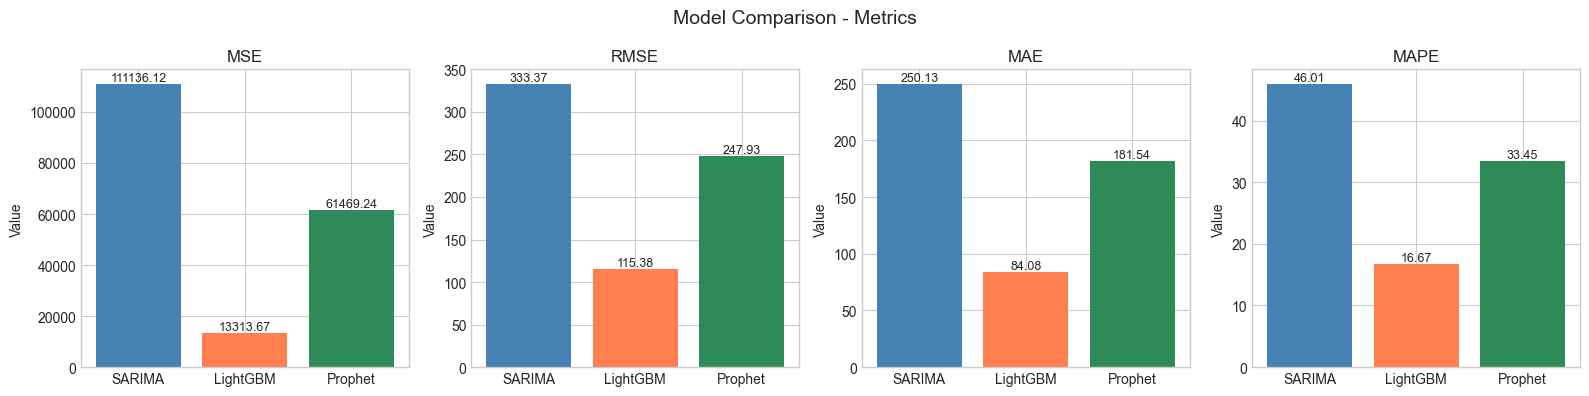

In [ ]:
# Visual comparison of metrics
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'MAPE']
colors = ['steelblue', 'coral', 'seagreen']

for i, metric in enumerate(metrics_to_plot):
    values = [model_results[m][metric] for m in model_results.keys()]
    bars = axes[i].bar(model_results.keys(), values, color=colors[:len(values)])
    axes[i].set_title(metric)
    axes[i].set_ylabel('Value')
    
    # Add value labels
    for bar, val in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Comparison - Metrics', fontsize=14)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Prediction Visualization

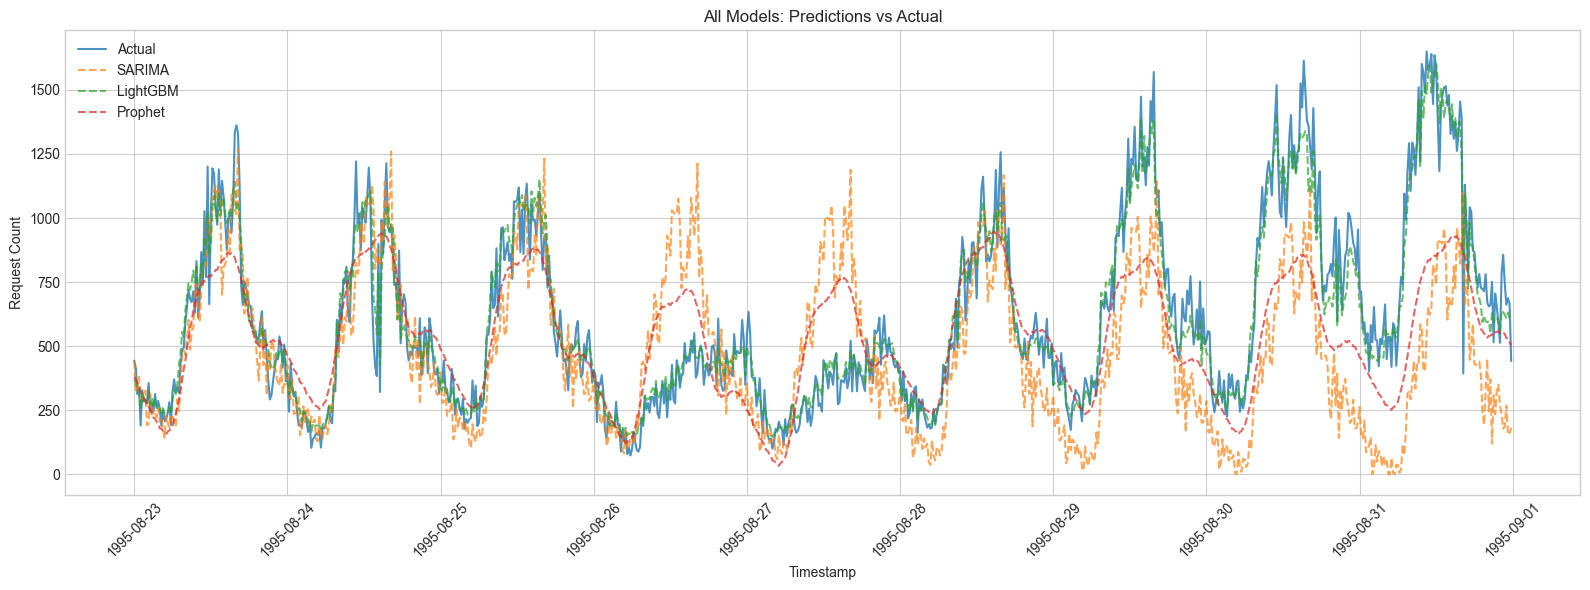

In [ ]:
# Plot all predictions vs actual
fig, ax = plt.subplots(figsize=(16, 6))

# Actual
ax.plot(test_series.index[:len(model_predictions['SARIMA'])], 
        test_series.values[:len(model_predictions['SARIMA'])], 
        label='Actual', alpha=0.8, linewidth=1.5)

# Each model
for model_name, preds in model_predictions.items():
    ax.plot(test_series.index[:len(preds)], preds, 
            label=model_name, alpha=0.7, linestyle='--')

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('All Models: Predictions vs Actual')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

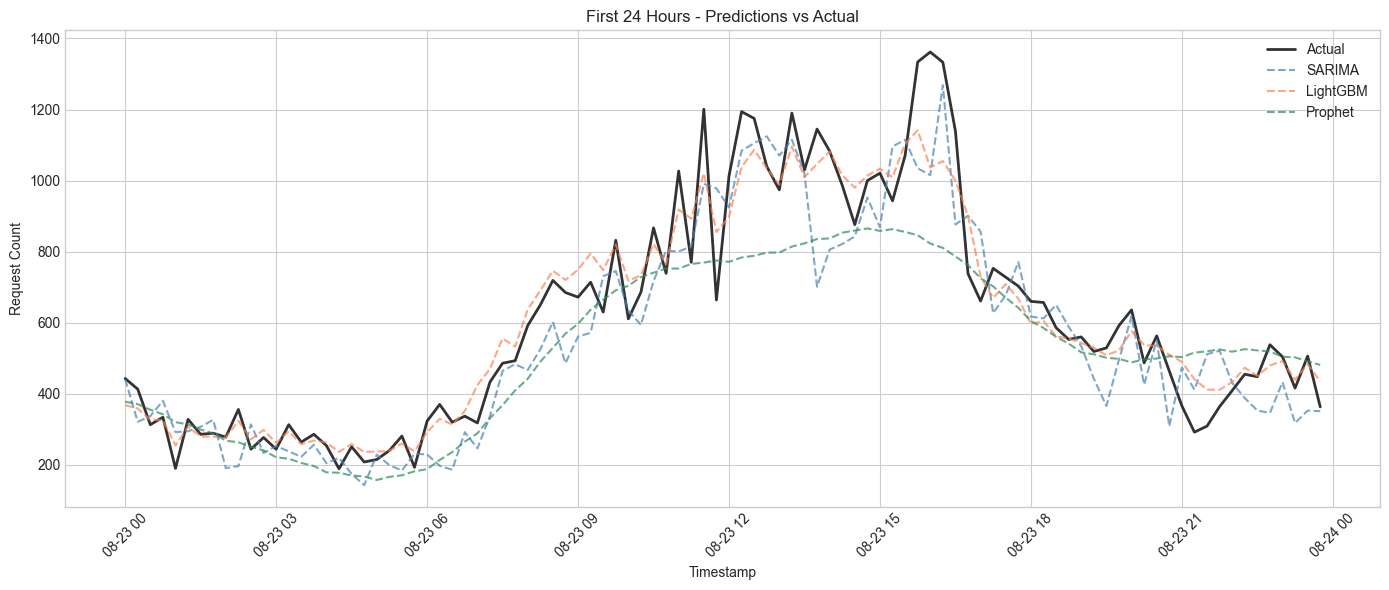

In [ ]:
# Zoom in on first day
first_day = 96  # 96 intervals = 24 hours

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(test_series.index[:first_day], test_series.values[:first_day], 
        label='Actual', alpha=0.8, linewidth=2, color='black')

colors = {'SARIMA': 'steelblue', 'LightGBM': 'coral', 'Prophet': 'seagreen'}
for model_name, preds in model_predictions.items():
    ax.plot(test_series.index[:first_day], preds[:first_day], 
            label=model_name, alpha=0.7, linestyle='--', 
            color=colors.get(model_name, 'gray'))

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('First 24 Hours - Predictions vs Actual')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison_day1.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Error Analysis by Time

In [ ]:
# Find minimum prediction length across all models
min_len = min(len(preds) for preds in model_predictions.values())

# Create error DataFrame with explicit lists to avoid index mismatch
error_df = pd.DataFrame({
    'timestamp': list(test_series.index[:min_len]),
    'actual': list(test_series.values[:min_len])
})

for model_name, preds in model_predictions.items():
    # Convert to list to avoid any index/array issues
    pred_values = list(preds[:min_len]) if hasattr(preds, '__iter__') else [preds] * min_len
    error_df[f'{model_name}_pred'] = pred_values
    error_df[f'{model_name}_error'] = [p - a for p, a in zip(pred_values, error_df['actual'])]
    error_df[f'{model_name}_abs_error'] = [abs(e) for e in error_df[f'{model_name}_error']]

error_df['hour'] = pd.to_datetime(error_df['timestamp']).dt.hour
error_df['day_of_week'] = pd.to_datetime(error_df['timestamp']).dt.dayofweek

print(f"Error analysis using {min_len} samples (minimum across all models)")
print(f"Models included: {list(model_predictions.keys())}")

ValueError: Length of values (863) does not match length of index (864)

In [ ]:
# Error by hour
fig, ax = plt.subplots(figsize=(12, 5))

for model_name in model_predictions.keys():
    hourly_error = error_df.groupby('hour')[f'{model_name}_abs_error'].mean()
    ax.plot(hourly_error.index, hourly_error.values, marker='o', label=model_name)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Prediction Error by Hour of Day')
ax.set_xticks(range(24))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/model_error_by_hour.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Error by day of week
fig, ax = plt.subplots(figsize=(10, 5))

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
x = np.arange(7)
width = 0.25

for i, model_name in enumerate(model_predictions.keys()):
    daily_error = error_df.groupby('day_of_week')[f'{model_name}_abs_error'].mean()
    ax.bar(x + i*width, daily_error.values, width, label=model_name)

ax.set_xlabel('Day of Week')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Prediction Error by Day of Week')
ax.set_xticks(x + width)
ax.set_xticklabels(days)
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/model_error_by_day.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Model Selection for Autoscaling

In [ ]:
# Ranking by different criteria
print("Model Rankings:")
print("="*60)

# By RMSE
rmse_ranking = sorted(model_results.items(), key=lambda x: x[1]['RMSE'])
print("\nBy RMSE (lower is better):")
for i, (model, metrics) in enumerate(rmse_ranking):
    print(f"  {i+1}. {model}: {metrics['RMSE']:.4f}")

# By MAE
mae_ranking = sorted(model_results.items(), key=lambda x: x[1]['MAE'])
print("\nBy MAE (lower is better):")
for i, (model, metrics) in enumerate(mae_ranking):
    print(f"  {i+1}. {model}: {metrics['MAE']:.4f}")

# By MAPE
mape_ranking = sorted(model_results.items(), key=lambda x: x[1]['MAPE'])
print("\nBy MAPE (lower is better):")
for i, (model, metrics) in enumerate(mape_ranking):
    print(f"  {i+1}. {model}: {metrics['MAPE']:.2f}%")

In [ ]:
# Best model for autoscaling
best_model = rmse_ranking[0][0]
best_metrics = rmse_ranking[0][1]

print(f"\nRecommended Model for Autoscaling: {best_model}")
print(f"RMSE: {best_metrics['RMSE']:.2f} requests/interval")
print(f"MAE: {best_metrics['MAE']:.2f} requests/interval")
print(f"MAPE: {best_metrics['MAPE']:.2f}%")

## 7. Save Models

In [ ]:
# Save all models
sarima.save('../models/sarima_15min.pkl')
lgbm.save('../models/lightgbm_15min.pkl')
if PROPHET_AVAILABLE:
    prophet.save('../models/prophet_15min.pkl')

print("All models saved!")

In [ ]:
# Save comparison results
comparison_df.to_csv('../reports/model_comparison_15min.csv', index=False)
print("Comparison results saved to: ../reports/model_comparison_15min.csv")

## 8. Summary

In [ ]:
print("="*70)
print("                    MODEL COMPARISON SUMMARY")
print("="*70)
print(f"\nGranularity: 15 minutes")
print(f"Test Period: {test.index.min()} to {test.index.max()}")
print(f"Test Samples: {len(test)}")
print(f"\n" + "-"*70)
print("PERFORMANCE METRICS:")
print("-"*70)
print(f"{'Model':<15} {'RMSE':<12} {'MAE':<12} {'MAPE':<12} {'Rank':<6}")
print("-"*70)

for i, (model, metrics) in enumerate(rmse_ranking):
    print(f"{model:<15} {metrics['RMSE']:<12.2f} {metrics['MAE']:<12.2f} {metrics['MAPE']:<12.2f}% {i+1:<6}")

print("-"*70)
print(f"\nBEST MODEL: {best_model}")
print(f"  - Lowest RMSE: {best_metrics['RMSE']:.2f} requests/interval")
print(f"  - Recommended for predictive autoscaling")
print(f"\nMODELS SAVED:")
print(f"  - ../models/sarima_15min.pkl")
print(f"  - ../models/lightgbm_15min.pkl")
if PROPHET_AVAILABLE:
    print(f"  - ../models/prophet_15min.pkl")
print("="*70)